In [9]:
# Use a voting classifier to combine several different classifiers
from sklearn.datasets import make_moons
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

X, y = make_moons(n_samples=500, noise=0.30)
X_train, X_test, y_train, y_test = train_test_split(X, y)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression()),
        ('rf', RandomForestClassifier()),
        ('svc', SVC())
    ]
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [10]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, '=', clf.score(X_test, y_test))

lr = 0.864
rf = 0.928
svc = 0.928


In [11]:
voting_clf.score(X_test, y_test)

0.928

In [12]:
# try soft voting
voting_clf.named_estimators['svc'].probability = True
voting_clf.voting = "soft"
voting_clf.fit(X_train, y_train)
voting_clf.score(X_test, y_test)

0.928

In [13]:
# bagging
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, n_jobs=-1)
bag_clf.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=500, n_jobs=-1)

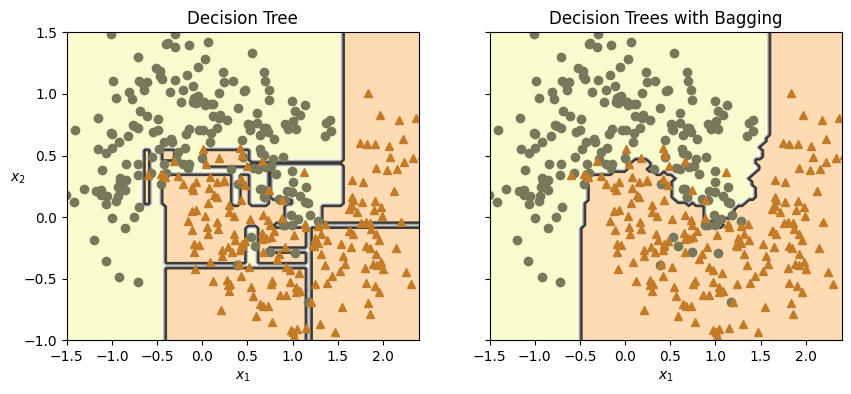

In [17]:
# visualize it compared to single decision tree
import matplotlib.pyplot as plt
import numpy as np

def plot_decision_boundary(clf, X, y, alpha=1.0):
    axes=[-1.5, 2.4, -1, 1.5]
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap='Wistia')
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8 * alpha)
    colors = ["#78785c", "#c47b27"]
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("Decision Tree")
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("Decision Trees with Bagging")
plt.ylabel("")
plt.show()

In [20]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, n_jobs=-1, oob_score=True)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9226666666666666

In [21]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_pred, y_test)

0.928

In [23]:
# Random forest
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)
accuracy_score(y_pred_rf, y_test)

0.92

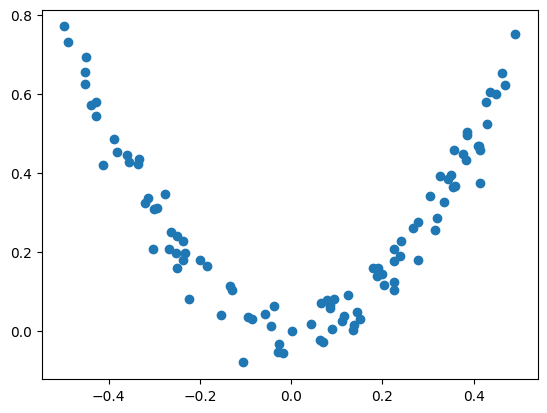

In [25]:
# gradient boosting - fit new trees to residual errors and add it to an ensemble
from sklearn.tree import DecisionTreeRegressor

X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0] ** 2 + 0.05 * np.random.randn(100)

plt.scatter(X, y)
plt.show()

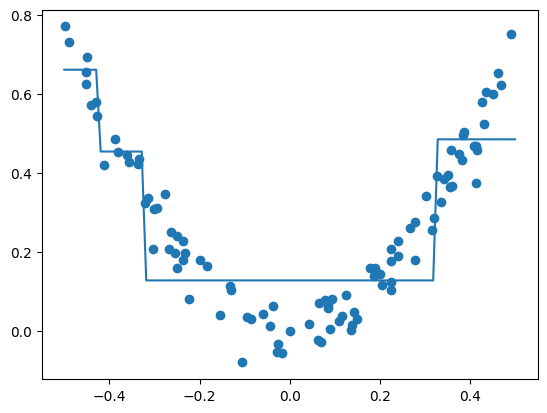

In [33]:
tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X, y)

X_space = np.linspace(-0.5, 0.5, 100).reshape(-1, 1)
plt.plot(X_space, tree_reg1.predict(X_space))
plt.scatter(X, y)
plt.show()

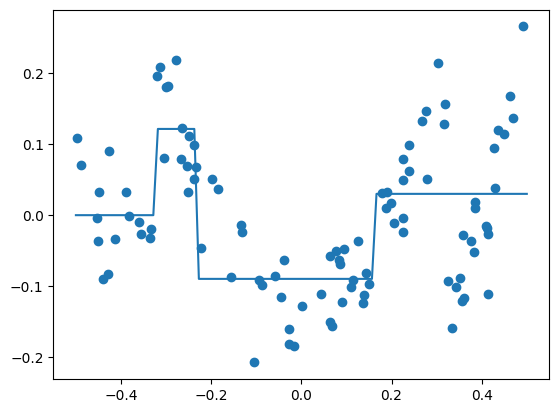

In [37]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

plt.plot(X_space, tree_reg2.predict(X_space))
plt.scatter(X, y2)
plt.show()

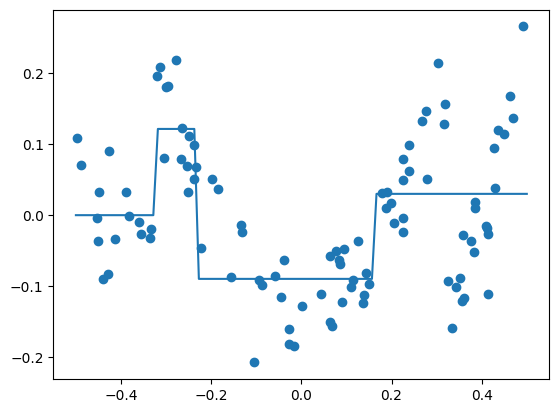

In [38]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

plt.plot(X_space, tree_reg2.predict(X_space))
plt.scatter(X, y2)
plt.show()

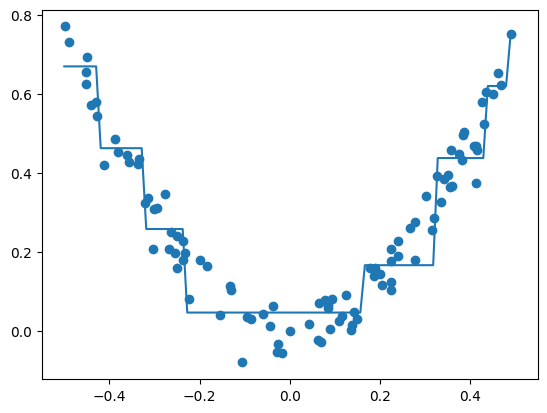

In [40]:
# now create an ensemble
y_pred = sum(tree.predict(X_space) for tree in (tree_reg1, tree_reg2, tree_reg3))
plt.plot(X_space, y_pred)
plt.scatter(X, y)
plt.show()

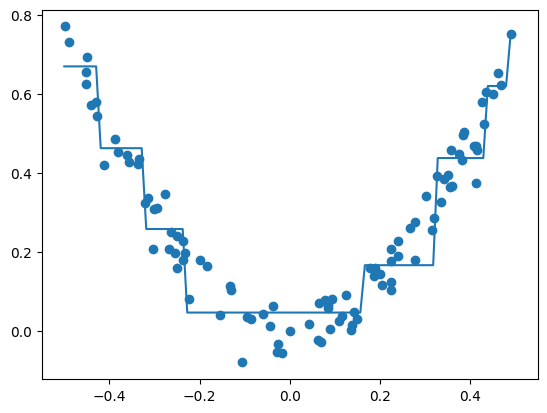

In [41]:
# or using built in methods
from sklearn.ensemble import GradientBoostingRegressor
gb_reg = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gb_reg.fit(X, y)

plt.plot(X_space, gb_reg.predict(X_space))
plt.scatter(X, y)
plt.show()

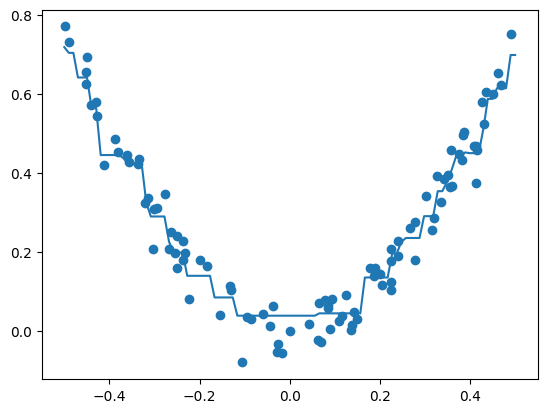

In [43]:
# train the ensemble with early stopping to find an ideal number of trees
gb_reg_best = GradientBoostingRegressor(
    max_depth=2, learning_rate=0.05, n_estimators=500, n_iter_no_change=10
)
gb_reg_best.fit(X, y)

plt.plot(X_space, gb_reg_best.predict(X_space))
plt.scatter(X, y)
plt.show()

In [44]:
# how many estimators did we actually use
gb_reg_best.n_estimators_

85

In [46]:
# stacking: train a new classifier with features as output of several classifiers
from sklearn.ensemble import StackingClassifier

stacking_clf = StackingClassifier(
    estimators = [
        ('lr', LogisticRegression()),
        ('rf', RandomForestClassifier()),
        ('svc', SVC(probability=True))
    ],
    final_estimator=RandomForestClassifier(),
    cv=5
)
stacking_clf.fit(X_train, y_train)

stacking_clf.score(X_test, y_test)

0.928